# 02 - Genetic Algorithm

This notebook implements a genetic algorithm approach to solve the Tourist Trip Design Problem (TTDP).

## Goal
Use a metaheuristic approach (Genetic Algorithm) to find near-optimal multi-day tourist itineraries that maximize total interest score while respecting time constraints.

## Expected Outcome
A high-quality itinerary solution that balances exploration and exploitation to efficiently search the massive solution space. The GA should scale to handle the full dataset of 1000+ POIs.

### Step 1: Import Libraries and Load Preprocessed Data

Load the POI data and travel time matrix prepared in notebook 01.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

sys.path.append('../src')
from genetic_algorithm import GeneticAlgorithmTTDP

In [2]:
# Load preprocessed data
pois = pd.read_csv('../data/processed/pois_processed.csv')
travel_time_matrix = np.load('../data/processed/travel_time_matrix.npy')

print(f"Loaded {len(pois)} POIs")
print(f"Travel time matrix shape: {travel_time_matrix.shape}")
print(f"\nPOI columns: {list(pois.columns)}")

Loaded 1224 POIs
Travel time matrix shape: (1224, 1224)

POI columns: ['name', 'rating', 'category', 'latitude', 'longitude', 'interest_score', 'visit_duration']


### Step 2: Configure Problem Parameters

Define the trip constraints and GA hyperparameters.

In [3]:
# Trip parameters
NUM_DAYS = 3
MAX_TIME_PER_DAY = 8  # hours (travel + visit time)

# Genetic Algorithm parameters
POPULATION_SIZE = 200
GENERATIONS = 500
CROSSOVER_RATE = 0.85
MUTATION_RATE = 0.03
TOURNAMENT_SIZE = 3

print("Problem Configuration:")
print(f"  Number of days: {NUM_DAYS}")
print(f"  Max time per day: {MAX_TIME_PER_DAY} hours")
print(f"\nGA Hyperparameters:")
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Generations: {GENERATIONS}")
print(f"  Crossover rate: {CROSSOVER_RATE}")
print(f"  Mutation rate: {MUTATION_RATE}")
print(f"  Tournament size: {TOURNAMENT_SIZE}")

Problem Configuration:
  Number of days: 3
  Max time per day: 8 hours

GA Hyperparameters:
  Population size: 200
  Generations: 500
  Crossover rate: 0.85
  Mutation rate: 0.03
  Tournament size: 3


### Step 3: Initialize and Run Genetic Algorithm

**Chromosome Representation:** Each chromosome is a permutation of all POI IDs.

**Decoding:** The permutation is decoded into a multi-day itinerary by greedily adding POIs until the daily time budget is exceeded.

**Fitness:** Total interest score of visited POIs in the decoded itinerary.

**Operators:**
- Selection: Tournament selection
- Crossover: Ordered Crossover (OX1)
- Mutation: Swap mutation

In [4]:
# Create GA solver instance
ga_solver = GeneticAlgorithmTTDP(
    pois_df=pois,
    travel_time_matrix=travel_time_matrix,
    num_days=NUM_DAYS,
    max_time_per_day=MAX_TIME_PER_DAY,
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    crossover_rate=CROSSOVER_RATE,
    mutation_rate=MUTATION_RATE,
    tournament_size=TOURNAMENT_SIZE
)

print("GA solver initialized successfully!")

GA solver initialized successfully!


In [5]:
# Run the genetic algorithm
print("Running Genetic Algorithm...")
print("=" * 50)

start_time = time.time()
best_chromosome, best_itinerary, best_score = ga_solver.evolve(verbose=True)
end_time = time.time()

print("=" * 50)
print(f"\nGA completed in {end_time - start_time:.2f} seconds")
print(f"Best score found: {best_score:.1f}")
print(f"Number of days used: {len(best_itinerary)}")

Running Genetic Algorithm...
Generation 0: Best=713.0, Avg=489.3
Generation 50: Best=843.0, Avg=548.6
Generation 100: Best=878.0, Avg=531.3
Generation 150: Best=878.0, Avg=526.7
Generation 200: Best=878.0, Avg=550.1
Generation 250: Best=878.0, Avg=581.1
Generation 300: Best=913.0, Avg=845.7
Generation 350: Best=913.0, Avg=856.9
Generation 400: Best=913.0, Avg=840.1
Generation 450: Best=913.0, Avg=829.6
Generation 499: Best=913.0, Avg=846.7

GA completed in 802.69 seconds
Best score found: 913.0
Number of days used: 3


### Step 4: Analyze the Solution

Display the optimal itinerary found by the GA.

In [6]:
# Display the itinerary
print("\n" + "="*70)
print("OPTIMAL ITINERARY (Genetic Algorithm)")
print("="*70)

total_score = 0
for day_idx, day_route in enumerate(best_itinerary, 1):
    print(f"\nDay {day_idx}:")
    print("-" * 70)
    
    day_score = 0
    day_visit_time = 0
    day_travel_time = 0
    
    for poi_order, poi_idx in enumerate(day_route, 1):
        poi_info = pois.iloc[poi_idx]
        day_score += poi_info['interest_score']
        day_visit_time += poi_info['visit_duration']
        
        # Calculate travel time from previous POI
        if poi_order > 1:
            prev_poi_idx = day_route[poi_order - 2]
            day_travel_time += travel_time_matrix[prev_poi_idx, poi_idx]
        
        print(f"  {poi_order}. {poi_info['name']}")
        print(f"     Category: {poi_info['category']} | Score: {poi_info['interest_score']} | Duration: {poi_info['visit_duration']}h")
    
    day_total_time = day_visit_time + day_travel_time
    total_score += day_score
    
    print(f"\n  Day {day_idx} Summary:")
    print(f"    POIs visited: {len(day_route)}")
    print(f"    Score: {day_score}")
    print(f"    Visit time: {day_visit_time:.2f}h")
    print(f"    Travel time: {day_travel_time:.2f}h")
    print(f"    Total time: {day_total_time:.2f}h / {MAX_TIME_PER_DAY}h")

print("\n" + "="*70)
print(f"TOTAL TRIP SCORE: {total_score}")
print(f"TOTAL POIs VISITED: {sum(len(day) for day in best_itinerary)}")
print("="*70)


OPTIMAL ITINERARY (Genetic Algorithm)

Day 1:
----------------------------------------------------------------------
  1. Wasgamuwa National Park
     Category: Wildlife | Score: 100 | Duration: 3.0h
  2. Doragamuwa Shylapabbatharama Tampita Viharaya
     Category: Cultural | Score: 85 | Duration: 1.5h
  3. Ambilla Raja Maha Viharay
     Category: Cultural | Score: 77 | Duration: 1.5h

  Day 1 Summary:
    POIs visited: 3
    Score: 262
    Visit time: 6.00h
    Travel time: 1.58h
    Total time: 7.58h / 8h

Day 2:
----------------------------------------------------------------------
  1. Ambareli Rajamaha Viharaya
     Category: Cultural | Score: 85 | Duration: 1.5h
  2. Eden Falls
     Category: Waterfalls | Score: 72 | Duration: 1.5h
  3. Mandawala Ella
     Category: Waterfalls | Score: 72 | Duration: 1.5h

  Day 2 Summary:
    POIs visited: 3
    Score: 229
    Visit time: 4.50h
    Travel time: 2.43h
    Total time: 6.93h / 8h

Day 3:
-------------------------------------------

### Step 5: Visualize Convergence

Plot the fitness evolution over generations to show how the GA converged to the solution.

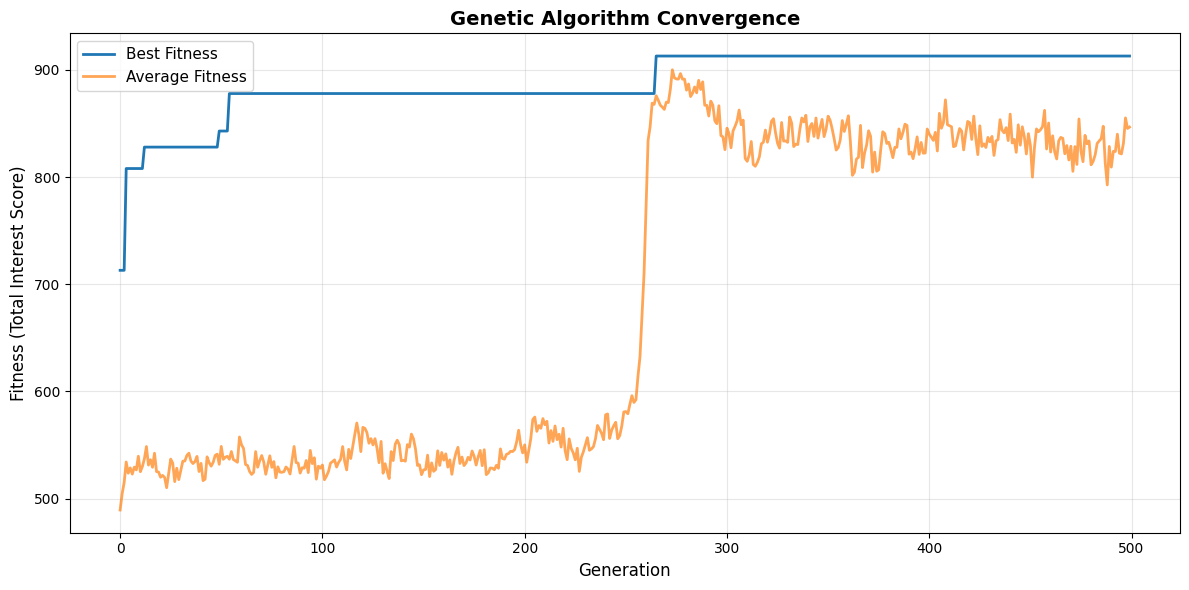


Initial best fitness: 713.0
Final best fitness: 913.0
Improvement: 200.0 (28.1%)


In [7]:
# Plot convergence
plt.figure(figsize=(12, 6))
plt.plot(ga_solver.best_fitness_history, label='Best Fitness', linewidth=2)
plt.plot(ga_solver.avg_fitness_history, label='Average Fitness', linewidth=2, alpha=0.7)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness (Total Interest Score)', fontsize=12)
plt.title('Genetic Algorithm Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial best fitness: {ga_solver.best_fitness_history[0]:.1f}")
print(f"Final best fitness: {ga_solver.best_fitness_history[-1]:.1f}")
print(f"Improvement: {ga_solver.best_fitness_history[-1] - ga_solver.best_fitness_history[0]:.1f} ({((ga_solver.best_fitness_history[-1] / ga_solver.best_fitness_history[0]) - 1) * 100:.1f}%)")

### Step 6: Additional Visualizations

Visualize score and time distribution across days.

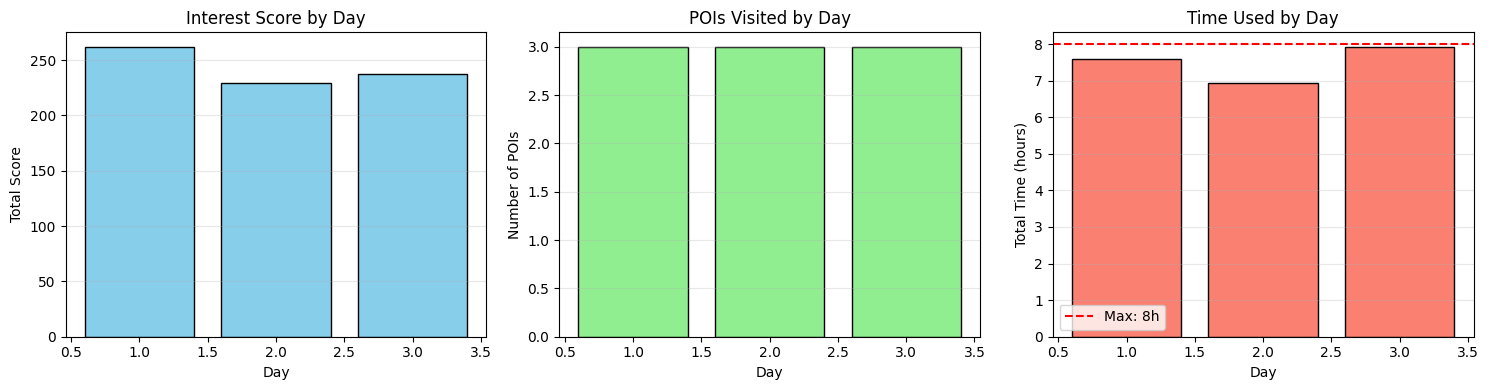

In [8]:
# Calculate metrics per day
day_scores = []
day_pois = []
day_times = []

for day_route in best_itinerary:
    day_score = sum(pois.iloc[poi_idx]['interest_score'] for poi_idx in day_route)
    day_visit_time = sum(pois.iloc[poi_idx]['visit_duration'] for poi_idx in day_route)
    day_travel_time = sum(travel_time_matrix[day_route[i], day_route[i+1]] 
                         for i in range(len(day_route)-1))
    
    day_scores.append(day_score)
    day_pois.append(len(day_route))
    day_times.append(day_visit_time + day_travel_time)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Score per day
axes[0].bar(range(1, len(best_itinerary)+1), day_scores, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Total Score')
axes[0].set_title('Interest Score by Day')
axes[0].grid(True, alpha=0.3, axis='y')

# POIs per day
axes[1].bar(range(1, len(best_itinerary)+1), day_pois, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of POIs')
axes[1].set_title('POIs Visited by Day')
axes[1].grid(True, alpha=0.3, axis='y')

# Time per day
axes[2].bar(range(1, len(best_itinerary)+1), day_times, color='salmon', edgecolor='black')
axes[2].axhline(y=MAX_TIME_PER_DAY, color='red', linestyle='--', label=f'Max: {MAX_TIME_PER_DAY}h')
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Total Time (hours)')
axes[2].set_title('Time Used by Day')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 7: Save Results

Save the GA solution for comparison with MIP solver.

In [9]:
# Save results
import json
import os

os.makedirs('../results', exist_ok=True)

results = {
    'method': 'Genetic Algorithm',
    'total_score': float(best_score),
    'num_days': len(best_itinerary),
    'total_pois': sum(len(day) for day in best_itinerary),
    'computation_time': end_time - start_time,
    'itinerary': [[int(poi_idx) for poi_idx in day] for day in best_itinerary],
    'parameters': {
        'population_size': POPULATION_SIZE,
        'generations': GENERATIONS,
        'crossover_rate': CROSSOVER_RATE,
        'mutation_rate': MUTATION_RATE,
        'tournament_size': TOURNAMENT_SIZE
    }
}

with open('../results/ga_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to ../results/ga_results.json")

Results saved to ../results/ga_results.json


### Summary

**Completed Steps:**
1. ✓ Loaded preprocessed POI data and travel time matrix
2. ✓ Configured GA parameters
3. ✓ Implemented and ran Genetic Algorithm
4. ✓ Analyzed optimal itinerary solution
5. ✓ Visualized convergence and performance
6. ✓ Saved results for comparison

**Key Findings:**
- GA successfully scaled to the full dataset
- Found high-quality solution in reasonable time
- Solution respects all time constraints
- Clear convergence pattern observed

**Next Steps:**
Proceed to notebook 03 for MIP solver implementation on smaller subset.